In [1]:
from PIL import Image
from PIL import ImageEnhance
from ripser import ripser
from persim import plot_diagrams
from sklearn import datasets
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.measurements import label

In [2]:
#Functions to Test:
#Taxi []
#cleanUp []
#ProcessLetter []
#getFirstBetti []
#getTopRight [], getTopLeft [], getBottomRight [], getBottomLeft [], getMiddlePixelHorizontally []
#joinTwoPixels  []
#joinMirror [x]
#bisectHorizontally [x], cap [x], underline [x]
#findLetter []

In [40]:
#Functions to clean and preprocess the image file. 

#Taxi computes the taxicab distance between two pictures
def taxi(p1,p2):
    return(abs(p1[0]-p2[0])+abs(p1[1]-p2[1]))

#cleanUp does a rudimentary DFS blob analysis to find the largest connected component of pixels, to try and 
#reduce noise
def cleanUp(letter):
    hashLetter = set([(p[0],p[1]) for p in letter])
    seenLetter = {(p[0],p[1]): False for p in letter}
    blobs = dict()
    blobCounter = 1
    for p in letter:
        if not seenLetter[(p[0],p[1])]:
            onStack = [(p[0],p[1])]
            seenLetter[(p[0],p[1])]=True
            blobs.update({blobCounter:[]})
            while onStack:
                q = onStack.pop()
                blobs[blobCounter].append(q)
                for i in range(-1,2):
                    for j in range(-1,2):
                        if (q[0]+i,q[1]+j) in seenLetter.keys() and not seenLetter[(q[0]+i,q[1]+j)]:
                            onStack.append((q[0]+i,q[1]+j))
                            seenLetter[(q[0]+i,q[1]+j)]=True
            blobCounter+=1                   
    m = 0
    for i in blobs.keys():
        if len(blobs[i])>m:
            m=len(blobs[i])
            mi = i
    return(np.asarray(blobs[mi]))

#processLetter takes an image file and turns it into an array of tuples [(x,y),...]. 
#The tuple (a,b) is in the array if and only if the corresponding pixel is ON (Black) in the 
#Black/White version of the image file. Explicitly, this returns the pixels of the text/written character.
def processLetter(letterImage):
    letter = Image.open(letterImage)
    letter = letter.convert('1')
    data = np.asarray(letter)
    rows,columns = data.shape
    pixelSpots = cleanUp([[j,-i] for i in range(rows) for j in range(columns) if not data[i][j]])
    m = min([pixel[1] for pixel in pixelSpots])
    n = min([pixel[0] for pixel in pixelSpots])
    for pixel in pixelSpots:
        pixel[1]-=m
        pixel[0]-=n
    pixelSpots = np.array(pixelSpots)
    return(pixelSpots)

In [4]:
#Given pixel locations, computes (first degree) persistent Betti homology using RIPSER.
#One can specify relevance and birth parameters. The relevance parameter tells the program how large a circle you are looking for
#i.e. if relevance is 5, the homology class must persist five units after its birth. 
#The birth describes when the homology class appears in the rips complex. A lower birth value requires the homology class
#to be born sooner. 

#Note that ripser also requires a 'thresh' parameter; this is yet to be optimized.

def getFirstBetti(pixels, relevance, birth = 3):
    dgms = ripser(pixels, thresh=10)['dgms']
    count = 0
    for data in dgms[1]:
        if abs(data[0]-data[1])>=relevance and data[0]<=birth:
            count+=1
    #plot_diagrams(dgms, show = True)
    return(count)

In [5]:
#Various helper functions which extract certain (possibly) relevant pixels out of a group. 
#Currently implemented: 
#Pixel from top right corner
#Pixel from bottom right corner
#Pixel from top left corner
#Pixel from bottom left corner
#Pixel closest to the average x-coordinate. 
#Warning: As with most functions in this document, these functions are built to assume that the picture is roughly 
#50x50 pixels. This will hopefully be more flexible in the near future. 


def getBottomRight(pixels):
    m = min([p[1] for p in pixels])
    bottomTier = [list(p) for p in pixels if abs(p[1]-m)<5]
    ma = -1
    for p in bottomTier:
        if p[0]>ma:
            ma = p[0]
            r = p
    return(r)

def getTopRight(pixels):
    m = max([p[1] for p in pixels])
    topTier = [list(p) for p in pixels if abs(p[1]-m)<5]
    ma = -1
    for p in topTier:
        if p[0]>ma:
            ma = p[0]
            r = p
    return(r)

def getTopLeft(pixels):
    m = max([p[1] for p in pixels])
    topTier = [list(p) for p in pixels if abs(p[1]-m)<5]
    ma = 100
    for p in topTier:
        if p[0]<=ma:
            ma = p[0]
            r = p
    return(p)

def getBottomLeft(pixels):
    m = min([p[1] for p in pixels])
    bottomTier = [list(p) for p in pixels if abs(p[1]-m)<5]
    ma = 100
    for p in bottomTier:
        if p[0]<=ma:
            ma = p[0]
            r = p
    return(r)

def getMiddlePixelHorizontally(pixels):
    l = [p[0] for p in pixels]
    avg = sum(l)/len(l)
    loss = 100
    for p in pixels:
        if abs(p[0]-avg) < loss:
            r = p
            loss =abs(p[0]-avg)
    return(r)

In [6]:
#Connects two pixels via a parametrized straight line. 
#Note: If the image of interest is larger than 50x50 pixels, one may want to make the "thick_param"
#value larger; this parameter essentially decides how thick to draw the line. 
def joinTwoPixels(p1,p2,pixels,thick_param=40):
    l = [list(p) for p in pixels]
    for t in range(0,thick_param+1):
        l.append([(t/thick_param)*p1[0]+(1-t/thick_param)*p2[0],(t/thick_param)*p1[1]+(1-t/thick_param)*p2[1]])
    return(np.asarray(l))

In [7]:
#joinMirror reflects a group of pixels across a boundary; either its upper, left, lower, or right-most boundary.
#It then merges the image with its reflection in this direction, and returns the merged pixel set.

def joinMirror(pixels, direction):
    assert direction in ['T','B','L','R']
    if direction == 'B':
        newPixelSet = [list(p) for p in pixels]
        for p in pixels:
            newPixelSet.append([p[0],-p[1]])
        return(np.asarray(newPixelSet))
    if direction == 'T':
        newPixelSet = [list(p) for p in pixels]
        m = max([p[1] for p in pixels])
        for p in pixels:
            newPixelSet.append([p[0],m+(m-p[1])])
        return(np.asarray(newPixelSet))
    if direction == 'L':
        newPixelSet = [list(p) for p in pixels]
        for p in pixels:
            newPixelSet.append([-p[0],p[1]])
        return(np.asarray(newPixelSet))
    if direction == 'R':
        newPixelSet = [list(p) for p in pixels]
        m = max([p[0] for p in pixels])
        for p in pixels:
            newPixelSet.append([2*m-p[0],p[1]])
        return(np.asarray(newPixelSet))

In [8]:
#These functions add various horizontal lines onto the image. Currently implemented:
#A horizontal line at the top of the pixels (cap)
#A horizontal line at the bottom of the pixels (underline)
#A horizontal line drawn at the average of the y-coordinates (horizontalBisect)

#Warning: As with the "joinPixels" function, these functions are all built for a 50x50 pixel image.

def horizontalBisect(pixels):
    l = [list(p) for p in pixels]
    ymax = max([p[1] for p in pixels])
    ymin = min([p[1] for p in pixels])
    yAvg = (ymax+ymin)/2
    xmin = min([p[0] for p in pixels])
    xmax = max([p[0] for p in pixels])
    for t in range(0,41):
        l.append([(t/40)*xmin + ((t-1)/40)*xmax,yAvg])
    return(np.asarray(l))

def verticalBisect(pixels):
    l = [list(p) for p in pixels]
    xmax = max([p[0] for p in pixels])
    xmin = min([p[0] for p in pixels])
    xAvg = (xmax+xmin)/2
    ymin = min([p[1] for p in pixels])
    ymax = max([p[1] for p in pixels])
    for t in range(0,41):
        l.append([xAvg,(t/40)*ymin + ((t-1)/40)*ymax])
    return(np.asarray(l))    

def cap(pixels):
    l = [list(p) for p in pixels]
    ymax = max([p[1] for p in pixels])
    xmin = min([p[0] for p in pixels])
    xmax = max([p[0] for p in pixels])
    for t in range(0,41):
        l.append([(t/40)*xmin + ((t-1)/40)*xmax,ymax])
    return(np.asarray(l))

def underline(pixels):
    l = [list(p) for p in pixels]
    ymin = min([p[1] for p in pixels])
    xmin = min([p[0] for p in pixels])
    xmax = max([p[0] for p in pixels])
    for t in range(0,41):
        l.append([(t/40)*xmin + ((t-1)/40)*xmax,ymin])
    return(np.asarray(l))

In [9]:
#The fundamental logic gates. Takes as input an image file and outputs classification. For more information, see
#included readme files. 

def findLetter(letter):
    pixels = processLetter(letter)
    firstBetti = getFirstBetti(pixels,3)
    if firstBetti == 2:
        return('B')
    elif firstBetti == 1:
        firstBettiBM = getFirstBetti(joinMirror(pixels,'B'),3)
        if firstBettiBM == 3:
            joinTrBr = joinTwoPixels(getTopRight(pixels),getBottomRight(pixels),pixels)
            if getFirstBetti(joinTrBr,3)==2:
                return('R')
            else:
                return('A')
        else:
            hBisect = horizontalBisect(pixels)
            if getFirstBetti(hBisect,3) == firstBetti:
                return('P')
            else:
                if getFirstBetti(joinMirror(pixels,'R'),3)==3:
                    return('Q')
                else:
                    if getFirstBetti(joinMirror(joinMirror(pixels,'L'),'B'),3)==5:
                        return('O')
                    else:
                        return('D')
    else:
        capBetti = getFirstBetti(cap(pixels),3)
        underBetti = getFirstBetti(underline(pixels),3)
        if capBetti >= 1:
            if underBetti == 0:
                if getFirstBetti(joinTwoPixels(getTopRight(pixels),getBottomRight(pixels),pixels),3)==1:
                    return('Y')
                else:
                    if getFirstBetti(joinTwoPixels(getTopRight(pixels),getBottomLeft(pixels),pixels),3)==1:
                        return('U')
                    else:
                        return('V')
            else:                 
                if getFirstBetti(joinTwoPixels(getTopLeft(pixels),getBottomLeft(pixels),pixels),6)==1:
                    return('X')
                elif getFirstBetti(joinTwoPixels(getTopRight(pixels),getBottomRight(pixels),pixels),6)==1:
                    return('K')
                elif getFirstBetti(horizontalBisect(pixels),3)==0:
                    if getFirstBetti(joinTwoPixels(getBottomLeft(pixels),getMiddlePixelHorizontally(pixels),pixels),2)==0:
                        return('W')
                    else:
                        return('H')
                elif getFirstBetti(joinTwoPixels(getTopLeft(pixels),getBottomRight(pixels),pixels),3)==0:
                    return('N')
                elif getFirstBetti(joinTwoPixels(getTopRight(pixels),getMiddlePixelHorizontally(pixels),pixels),3)==0:
                    return('M')
                
        else:
            if getFirstBetti(horizontalBisect(pixels),3) == 1:
                return('G')
            elif getFirstBetti(joinTwoPixels(getTopLeft(pixels),getBottomRight(pixels),pixels),2) == 2:
                if getFirstBetti(joinTwoPixels(getTopRight(pixels),getBottomLeft(pixels),pixels),2)==0:
                    return('Z')
                if getFirstBetti(verticalBisect(pixels),3) == 0:
                    return('I')
                else:
                    return('E')
            elif getFirstBetti(joinMirror(pixels,'R'),3,birth = 5) == 0:
                if getFirstBetti(joinTwoPixels(getTopLeft(pixels),getBottomLeft(pixels),pixels),5) == 0:
                    return('L')
                elif getFirstBetti(joinMirror(cap(pixels),'L'),3) == 0:
                    return('T')
                else:
                    return('J')
            else:
                if getFirstBetti(cap(joinMirror(pixels,'R')),3) == 0:
                    return('F')
                elif getFirstBetti(cap(horizontalBisect(joinMirror(pixels,'R'))),3) == 1:
                    return('S')
                elif getFirstBetti(verticalBisect(pixels),3) == 1:
                    return('C')
                else:
                    return('E')
    return('I do not know what this letter is.')



In [151]:
filePrefix = './LetterFiles/TypefacedLetters/'
Letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for char in Letters:
    print(char,findLetter(filePrefix+char+'.png'))


A A
B B
C C
D D
E E
F F
G G
H H
I I
J J
K K
L L
M M
N N
O O
P P
Q Q
R R
S S
T T
U U
V V
W W
X X
Y Y
Z Z


In [30]:
file = './LetterFiles/HandwrittienLetters/L.png'
findLetter(file)

'L'

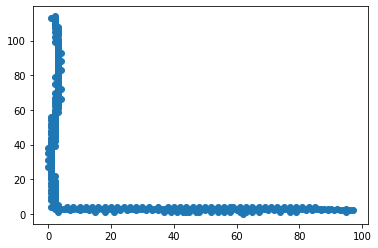

In [25]:
plt.scatter(photo[:,0],photo[:,1])

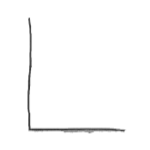

In [26]:
Drew = Image.open(file)
Drew

In [27]:
Drew = Drew.convert('1')

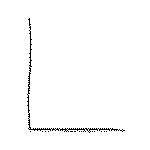

In [28]:
Drew

In [31]:
file = './LetterFiles/HandwrittienLetters/luke.png'
findLetter(file)

'L'

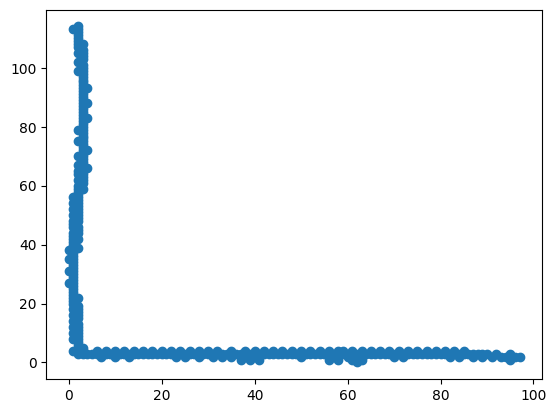

In [41]:
pixels = processLetter(file)
plt.scatter(pixels[:,0],pixels[:,1])

In [42]:
getFirstBetti(pixels,3)

0

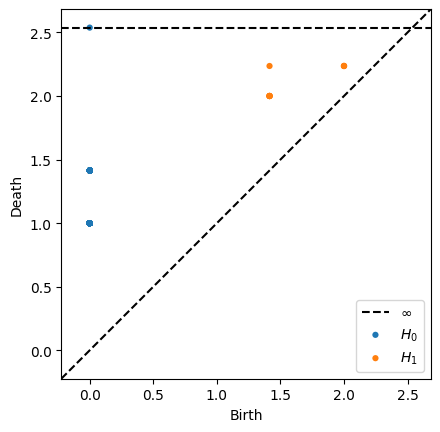

In [43]:
RIP = ripser(pixels, thresh=10)['dgms']
plot_diagrams(RIP, show=True)